In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch import nn
from torch.nn import functional as F
from torchsummary import summary
from torch.utils.data import random_split, DataLoader
from torchvision import datasets, transforms
from torchvision.utils import make_grid
from torch.autograd import Variable
from tqdm.auto import tqdm
import imageio

device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

c:\Users\dagam\AppData\Local\Programs\Python\Python311\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


'cuda'

In [2]:
transform_train = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize([0.5], [0.5])
        ])
to_image = transforms.ToPILImage()

torch.manual_seed(42)

train_data = datasets.MNIST(
    root="data/",
    train=True,
    download=True,
    transform=transform_train,
    )

trainloader = DataLoader(train_data, batch_size=100, shuffle=True)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


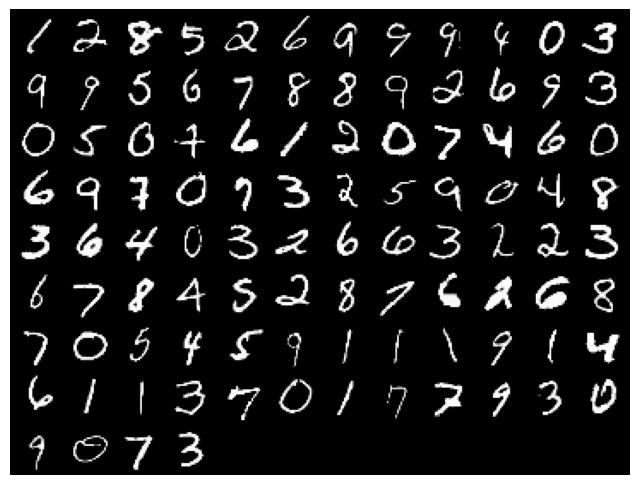

In [3]:
for images, labels in trainloader:
    plt.figure(figsize=(8,20))
    plt.axis('off')
    plt.imshow(make_grid(images, nrow=12).permute((1, 2, 0)))
    break

In [4]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.n_features = 128
        self.n_out = 784
        self.fc0 = nn.Sequential(
                    nn.Linear(self.n_features, 256),
                    nn.LeakyReLU(0.2)
                    )
        self.fc1 = nn.Sequential(
                    nn.Linear(256, 512),
                    nn.LeakyReLU(0.2)
                    )
        self.fc2 = nn.Sequential(
                    nn.Linear(512, 1024),
                    nn.LeakyReLU(0.2)
                    )
        self.fc3 = nn.Sequential(
                    nn.Linear(1024, self.n_out),
                    nn.Tanh()
                    )
    def forward(self, x):
        x = self.fc0(x)
        x = self.fc1(x)
        x = self.fc2(x)
        x = self.fc3(x)
        x = x.view(-1, 1, 28, 28)
        return x

class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.n_in = 784
        self.n_out = 1
        self.fc0 = nn.Sequential(
                    nn.Linear(self.n_in, 1024),
                    nn.LeakyReLU(0.2),
                    nn.Dropout(0.3)
                    )
        self.fc1 = nn.Sequential(
                    nn.Linear(1024, 512),
                    nn.LeakyReLU(0.2),
                    nn.Dropout(0.3)
                    )
        self.fc2 = nn.Sequential(
                    nn.Linear(512, 256),
                    nn.LeakyReLU(0.2),
                    nn.Dropout(0.3)
                    )
        self.fc3 = nn.Sequential(
                    nn.Linear(256, self.n_out),
                    nn.Sigmoid()
                    )
    def forward(self, x):
        x = x.view(-1, 784)
        x = self.fc0(x)
        x = self.fc1(x)
        x = self.fc2(x)
        x = self.fc3(x)
        return x
    
generator = Generator().to(device)
discriminator = Discriminator().to(device)

In [5]:
summary(generator, (128,128))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1             [-1, 128, 256]          33,024
         LeakyReLU-2             [-1, 128, 256]               0
            Linear-3             [-1, 128, 512]         131,584
         LeakyReLU-4             [-1, 128, 512]               0
            Linear-5            [-1, 128, 1024]         525,312
         LeakyReLU-6            [-1, 128, 1024]               0
            Linear-7             [-1, 128, 784]         803,600
              Tanh-8             [-1, 128, 784]               0
Total params: 1,493,520
Trainable params: 1,493,520
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.06
Forward/backward pass size (MB): 5.03
Params size (MB): 5.70
Estimated Total Size (MB): 10.79
----------------------------------------------------------------


In [6]:
criterion = nn.BCELoss()
g_optim = torch.optim.Adam(generator.parameters(), lr=2e-4)
d_optim = torch.optim.Adam(discriminator.parameters(), lr=2e-4)

g_losses = []
d_losses = []
images = []


def noise(n, n_features=128):
    return Variable(torch.randn(n, n_features)).to(device)

def make_ones(size):
    data = Variable(torch.ones(size, 1))
    return data.to(device)

def make_zeros(size):
    data = Variable(torch.zeros(size, 1))
    return data.to(device)

def train_discriminator(optimizer, real_data, fake_data):
    n = real_data.size(0)

    optimizer.zero_grad()
    
    prediction_real = discriminator(real_data)
    error_real = criterion(prediction_real, make_ones(n))
    error_real.backward()

    prediction_fake = discriminator(fake_data)
    error_fake = criterion(prediction_fake, make_zeros(n))
    
    error_fake.backward()
    optimizer.step()
    
    return error_real + error_fake

def train_generator(optimizer, fake_data):
    n = fake_data.size(0)
    optimizer.zero_grad()
    
    prediction = discriminator(fake_data)
    error = criterion(prediction, make_ones(n))
    
    error.backward()
    optimizer.step()
    
    return error

In [ ]:
num_epochs = 250
k = 1
test_noise = noise(64)

generator.train()
discriminator.train()
for epoch in tqdm(range(num_epochs)):
    g_error = 0.0
    d_error = 0.0
    for i, data in enumerate(trainloader):
        imgs, _ = data
        n = len(imgs)
        for j in range(k):
            fake_data = generator(noise(n)).detach()
            real_data = imgs.to(device)
            d_error += train_discriminator(d_optim, real_data, fake_data)
        fake_data = generator(noise(n))
        g_error += train_generator(g_optim, fake_data)

    img = generator(test_noise).cpu().detach()
    img = make_grid(img)
    images.append(img)
    g_losses.append(g_error/i)
    d_losses.append(d_error/i)
    print(f"Epoch {epoch}: g_loss: {g_error/i:.8f} d_loss: {d_error/i:.8f}")
    
print('Training Finished')
torch.save(generator.state_dict(), 'mnist_generator.pth')

Epoch 0: g_loss: 3.65258694 d_loss: 0.77141213


Epoch 1: g_loss: 2.73515058 d_loss: 0.92513543


Epoch 2: g_loss: 2.07056308 d_loss: 0.87449712


Epoch 3: g_loss: 2.89352131 d_loss: 0.52514762


Epoch 4: g_loss: 3.05467367 d_loss: 0.46845582


Epoch 5: g_loss: 2.84653950 d_loss: 0.54514116


Epoch 6: g_loss: 2.93004203 d_loss: 0.50210142


Epoch 7: g_loss: 2.59339809 d_loss: 0.58373827


Epoch 8: g_loss: 2.36339402 d_loss: 0.65935910


Epoch 9: g_loss: 2.35482502 d_loss: 0.63101381


Epoch 10: g_loss: 2.42626572 d_loss: 0.62963217


Epoch 11: g_loss: 2.21242452 d_loss: 0.68902415


Epoch 12: g_loss: 2.05560827 d_loss: 0.73302114


Epoch 13: g_loss: 2.00808930 d_loss: 0.75134492


Epoch 14: g_loss: 1.93877327 d_loss: 0.79770184


Epoch 15: g_loss: 1.95105326 d_loss: 0.80230820


Epoch 16: g_loss: 1.87728405 d_loss: 0.80452895


Epoch 17: g_loss: 1.72651434 d_loss: 0.85959077


Epoch 18: g_loss: 1.70828557 d_loss: 0.86115098


Epoch 19: g_loss: 1.57818747 d_loss: 0.93669999


Epoch 20: g_loss: 1.58363509 d_loss: 0.92715567


Epoch 21: g_loss: 1.54095948 d_loss: 0.95109826


Epoch 22: g_loss: 1.60308206 d_loss: 0.91986877


Epoch 23: g_loss: 1.57140815 d_loss: 0.93595749


Epoch 24: g_loss: 1.50457644 d_loss: 0.96939397


Epoch 25: g_loss: 1.45917881 d_loss: 0.97588313


Epoch 26: g_loss: 1.50909150 d_loss: 0.97272062


Epoch 27: g_loss: 1.44436502 d_loss: 0.99278527


Epoch 28: g_loss: 1.44129634 d_loss: 0.98067963


Epoch 29: g_loss: 1.34110403 d_loss: 1.02831972


Epoch 30: g_loss: 1.35523570 d_loss: 1.03550160


Epoch 31: g_loss: 1.30714691 d_loss: 1.03776062


Epoch 32: g_loss: 1.30733740 d_loss: 1.05058742


Epoch 33: g_loss: 1.32921767 d_loss: 1.04758942


Epoch 34: g_loss: 1.29622889 d_loss: 1.05483711


Epoch 35: g_loss: 1.29634452 d_loss: 1.05380344


Epoch 36: g_loss: 1.31184292 d_loss: 1.05136299


Epoch 37: g_loss: 1.29923236 d_loss: 1.05485904


Epoch 38: g_loss: 1.26033008 d_loss: 1.06796265


Epoch 39: g_loss: 1.23546386 d_loss: 1.08804655


Epoch 40: g_loss: 1.23363018 d_loss: 1.09236085


Epoch 41: g_loss: 1.19783700 d_loss: 1.10765421


Epoch 42: g_loss: 1.16287017 d_loss: 1.11648893


Epoch 43: g_loss: 1.17522311 d_loss: 1.11632729


Epoch 44: g_loss: 1.18468356 d_loss: 1.11434102


Epoch 45: g_loss: 1.14352942 d_loss: 1.13144040


Epoch 46: g_loss: 1.11100817 d_loss: 1.15092254


Epoch 47: g_loss: 1.12842989 d_loss: 1.14489675


Epoch 48: g_loss: 1.10517514 d_loss: 1.15842807


Epoch 49: g_loss: 1.11658609 d_loss: 1.15770650


Epoch 50: g_loss: 1.09738803 d_loss: 1.15654624


Epoch 51: g_loss: 1.07179987 d_loss: 1.17167091


Epoch 52: g_loss: 1.06897330 d_loss: 1.17829609


Epoch 53: g_loss: 1.10468495 d_loss: 1.15589643


Epoch 54: g_loss: 1.05206132 d_loss: 1.18749022


Epoch 55: g_loss: 1.06539583 d_loss: 1.17363024


Epoch 56: g_loss: 1.06174052 d_loss: 1.17585731


Epoch 57: g_loss: 1.03082728 d_loss: 1.19859719


Epoch 58: g_loss: 1.04655778 d_loss: 1.20045614


Epoch 59: g_loss: 1.02538121 d_loss: 1.19882238


Epoch 60: g_loss: 1.04935002 d_loss: 1.19439280


Epoch 61: g_loss: 1.04734337 d_loss: 1.18721163


Epoch 62: g_loss: 1.03073454 d_loss: 1.19807112


Epoch 63: g_loss: 1.03387642 d_loss: 1.20247352


Epoch 64: g_loss: 1.02350640 d_loss: 1.20234275


Epoch 65: g_loss: 1.00674093 d_loss: 1.20921564


Epoch 66: g_loss: 1.03020060 d_loss: 1.19986093


Epoch 67: g_loss: 1.01832259 d_loss: 1.20354033


Epoch 68: g_loss: 1.01829100 d_loss: 1.20176768


Epoch 69: g_loss: 1.01542938 d_loss: 1.20825481


Epoch 70: g_loss: 1.02952492 d_loss: 1.20000088


Epoch 71: g_loss: 0.99996561 d_loss: 1.21439803


Epoch 72: g_loss: 1.02099442 d_loss: 1.21460283


Epoch 73: g_loss: 1.00794017 d_loss: 1.21331871


Epoch 74: g_loss: 1.01543999 d_loss: 1.21120381


Epoch 75: g_loss: 0.97986090 d_loss: 1.22376692


Epoch 76: g_loss: 0.99251395 d_loss: 1.22193241


Epoch 77: g_loss: 0.99991721 d_loss: 1.21270502


Epoch 78: g_loss: 0.96607327 d_loss: 1.24005640


Epoch 79: g_loss: 0.99230075 d_loss: 1.22841227


Epoch 80: g_loss: 1.01510525 d_loss: 1.21197605


Epoch 81: g_loss: 0.97118759 d_loss: 1.22927189


Epoch 82: g_loss: 0.98302382 d_loss: 1.23625827


Epoch 83: g_loss: 0.97444713 d_loss: 1.22760797


Epoch 84: g_loss: 0.96920013 d_loss: 1.23374617


Epoch 85: g_loss: 0.97236937 d_loss: 1.23763454


Epoch 86: g_loss: 0.96155322 d_loss: 1.24124753


Epoch 87: g_loss: 0.97185880 d_loss: 1.23966444


Epoch 88: g_loss: 0.96133077 d_loss: 1.24121046


Epoch 89: g_loss: 0.96216410 d_loss: 1.24277830


Epoch 90: g_loss: 0.95913666 d_loss: 1.24482226


Epoch 91: g_loss: 0.96822876 d_loss: 1.24562085


Epoch 92: g_loss: 0.95437056 d_loss: 1.24294400


Epoch 93: g_loss: 0.94775772 d_loss: 1.24937081


Epoch 94: g_loss: 0.96618152 d_loss: 1.23437834


Epoch 95: g_loss: 0.95725089 d_loss: 1.24433601


Epoch 96: g_loss: 0.94299018 d_loss: 1.25271475


Epoch 97: g_loss: 0.94292086 d_loss: 1.24424803


Epoch 98: g_loss: 0.94147724 d_loss: 1.25134706


Epoch 99: g_loss: 0.94109881 d_loss: 1.25595450


Epoch 100: g_loss: 0.92512143 d_loss: 1.25769556


Epoch 101: g_loss: 0.94129312 d_loss: 1.24636912


Epoch 102: g_loss: 0.94561154 d_loss: 1.25922310


Epoch 103: g_loss: 0.93763918 d_loss: 1.25665843


Epoch 104: g_loss: 0.92975003 d_loss: 1.25501955


Epoch 105: g_loss: 0.92141849 d_loss: 1.26232433


Epoch 106: g_loss: 0.92387944 d_loss: 1.26380181


Epoch 107: g_loss: 0.92443705 d_loss: 1.25965106


Epoch 108: g_loss: 0.92889750 d_loss: 1.26024473


Epoch 109: g_loss: 0.94021833 d_loss: 1.25422072


Epoch 110: g_loss: 0.92755830 d_loss: 1.26032770


Epoch 111: g_loss: 0.91544384 d_loss: 1.27119350


Epoch 112: g_loss: 0.94003636 d_loss: 1.25362778


Epoch 113: g_loss: 0.92169321 d_loss: 1.26091051


Epoch 114: g_loss: 0.92812788 d_loss: 1.26786816


Epoch 115: g_loss: 0.92422968 d_loss: 1.25734127


Epoch 116: g_loss: 0.91783160 d_loss: 1.26763368


Epoch 117: g_loss: 0.93166637 d_loss: 1.26056969


Epoch 118: g_loss: 0.92398053 d_loss: 1.26380455


Epoch 119: g_loss: 0.92311209 d_loss: 1.26058841


Epoch 120: g_loss: 0.91294551 d_loss: 1.26937461


Epoch 121: g_loss: 0.91430110 d_loss: 1.26728725


Epoch 122: g_loss: 0.91400915 d_loss: 1.26938558


Epoch 123: g_loss: 0.92204338 d_loss: 1.26615095


Epoch 124: g_loss: 0.91557765 d_loss: 1.26900661


Epoch 125: g_loss: 0.92167485 d_loss: 1.26249123


Epoch 126: g_loss: 0.92399776 d_loss: 1.26698363


Epoch 127: g_loss: 0.90788877 d_loss: 1.27081311


Epoch 128: g_loss: 0.91556990 d_loss: 1.26510453


Epoch 129: g_loss: 0.92978448 d_loss: 1.26075351


Epoch 130: g_loss: 0.92443466 d_loss: 1.26527989


Epoch 131: g_loss: 0.91413003 d_loss: 1.26864791


Epoch 132: g_loss: 0.90676188 d_loss: 1.27138698


Epoch 133: g_loss: 0.90766042 d_loss: 1.27592468


Epoch 134: g_loss: 0.90080351 d_loss: 1.27034819


Epoch 135: g_loss: 0.92222446 d_loss: 1.26620114


Epoch 136: g_loss: 0.91692615 d_loss: 1.26508844


Epoch 137: g_loss: 0.90956348 d_loss: 1.26946950


Epoch 138: g_loss: 0.90184492 d_loss: 1.27751839


Epoch 139: g_loss: 0.90568638 d_loss: 1.26703954


Epoch 140: g_loss: 0.90241110 d_loss: 1.27621377


Epoch 141: g_loss: 0.90356147 d_loss: 1.26978385


Epoch 142: g_loss: 0.89110011 d_loss: 1.27577376


Epoch 143: g_loss: 0.88458401 d_loss: 1.28475928


Epoch 144: g_loss: 0.90512544 d_loss: 1.27383792


Epoch 145: g_loss: 0.90740341 d_loss: 1.27115464


Epoch 146: g_loss: 0.90474969 d_loss: 1.27249539


Epoch 147: g_loss: 0.89329159 d_loss: 1.27433026


Epoch 148: g_loss: 0.88574636 d_loss: 1.28024197


Epoch 149: g_loss: 0.89607555 d_loss: 1.27662981


Epoch 150: g_loss: 0.90818560 d_loss: 1.27080643


Epoch 151: g_loss: 0.90027577 d_loss: 1.28122830


Epoch 152: g_loss: 0.91194701 d_loss: 1.26975441


Epoch 153: g_loss: 0.90789998 d_loss: 1.27027643


Epoch 154: g_loss: 0.89715320 d_loss: 1.27408826


Epoch 155: g_loss: 0.89462608 d_loss: 1.27881694


Epoch 156: g_loss: 0.89468765 d_loss: 1.28138196


Epoch 157: g_loss: 0.89320129 d_loss: 1.28058040


Epoch 158: g_loss: 0.89243311 d_loss: 1.27943456


Epoch 159: g_loss: 0.88157457 d_loss: 1.28487802


Epoch 160: g_loss: 0.88715911 d_loss: 1.28482616


Epoch 161: g_loss: 0.89674950 d_loss: 1.27718174


Epoch 162: g_loss: 0.89029491 d_loss: 1.28061080


Epoch 163: g_loss: 0.88795841 d_loss: 1.28112733


Epoch 164: g_loss: 0.87969935 d_loss: 1.28439760


Epoch 165: g_loss: 0.88427049 d_loss: 1.28630769


Epoch 166: g_loss: 0.88789141 d_loss: 1.28338599


Epoch 167: g_loss: 0.90320402 d_loss: 1.27861714


Epoch 168: g_loss: 0.89521617 d_loss: 1.28173625


Epoch 169: g_loss: 0.89069927 d_loss: 1.28184426


Epoch 170: g_loss: 0.89744490 d_loss: 1.28319621


Epoch 171: g_loss: 0.89169276 d_loss: 1.27928829


Epoch 172: g_loss: 0.88633579 d_loss: 1.28243196


Epoch 173: g_loss: 0.88768184 d_loss: 1.28445280


Epoch 174: g_loss: 0.88514853 d_loss: 1.28501916


Epoch 175: g_loss: 0.87598884 d_loss: 1.28157401


Epoch 176: g_loss: 0.88229895 d_loss: 1.28351235


Epoch 177: g_loss: 0.88635957 d_loss: 1.28639746


Epoch 178: g_loss: 0.88947487 d_loss: 1.28279090


Epoch 179: g_loss: 0.89272320 d_loss: 1.28168285


Epoch 180: g_loss: 0.87947297 d_loss: 1.28596449


Epoch 181: g_loss: 0.89567477 d_loss: 1.28212893


Epoch 182: g_loss: 0.89202237 d_loss: 1.28190422


Epoch 183: g_loss: 0.87923807 d_loss: 1.28319430


Epoch 184: g_loss: 0.88880932 d_loss: 1.27939546


Epoch 185: g_loss: 0.87678874 d_loss: 1.28340340


Epoch 186: g_loss: 0.88993889 d_loss: 1.28530979


Epoch 187: g_loss: 0.89615571 d_loss: 1.28193510


Epoch 188: g_loss: 0.87653983 d_loss: 1.28396380


Epoch 189: g_loss: 0.87537426 d_loss: 1.28878832


Epoch 190: g_loss: 0.88822097 d_loss: 1.28480804


Epoch 191: g_loss: 0.88256168 d_loss: 1.28513992


Epoch 192: g_loss: 0.88704795 d_loss: 1.28350842


Epoch 193: g_loss: 0.88440722 d_loss: 1.28054476


Epoch 194: g_loss: 0.88143456 d_loss: 1.28502214


Epoch 195: g_loss: 0.88520974 d_loss: 1.28224969


Epoch 196: g_loss: 0.88292933 d_loss: 1.28283012


Epoch 197: g_loss: 0.89647985 d_loss: 1.28594422


Epoch 198: g_loss: 0.88853377 d_loss: 1.28629696


Epoch 199: g_loss: 0.88453817 d_loss: 1.28221035


Epoch 200: g_loss: 0.88096774 d_loss: 1.28740251


Epoch 201: g_loss: 0.87968713 d_loss: 1.28681064


Epoch 202: g_loss: 0.89180350 d_loss: 1.28040564


Epoch 203: g_loss: 0.88053441 d_loss: 1.28277147


Epoch 204: g_loss: 0.89689487 d_loss: 1.27788568


Epoch 205: g_loss: 0.89077163 d_loss: 1.28213620


Epoch 206: g_loss: 0.87972403 d_loss: 1.28173220


Epoch 207: g_loss: 0.88832885 d_loss: 1.28154027


Epoch 208: g_loss: 0.88118237 d_loss: 1.28685546


Epoch 209: g_loss: 0.87762195 d_loss: 1.29102468


Epoch 210: g_loss: 0.89025283 d_loss: 1.27977800


Epoch 211: g_loss: 0.88295037 d_loss: 1.28701758


Epoch 212: g_loss: 0.88790333 d_loss: 1.28666246


Epoch 213: g_loss: 0.88215679 d_loss: 1.28332233


Epoch 214: g_loss: 0.87438017 d_loss: 1.28944886


Epoch 215: g_loss: 0.88672584 d_loss: 1.28405488


Epoch 216: g_loss: 0.88348395 d_loss: 1.28710580


Epoch 217: g_loss: 0.89321727 d_loss: 1.28399241


Epoch 218: g_loss: 0.88271433 d_loss: 1.28296649


Epoch 219: g_loss: 0.87729168 d_loss: 1.29206252


Epoch 220: g_loss: 0.88722688 d_loss: 1.28550196


Epoch 221: g_loss: 0.87514699 d_loss: 1.29062903


Epoch 222: g_loss: 0.88745809 d_loss: 1.28633451


Epoch 223: g_loss: 0.87581718 d_loss: 1.28819585


Epoch 224: g_loss: 0.87276661 d_loss: 1.29083741


Epoch 225: g_loss: 0.87187707 d_loss: 1.29027021


Epoch 226: g_loss: 0.88782716 d_loss: 1.28458714


Epoch 227: g_loss: 0.88227659 d_loss: 1.28495741


Epoch 228: g_loss: 0.87791419 d_loss: 1.28922760


Epoch 229: g_loss: 0.87251729 d_loss: 1.29427910


Epoch 230: g_loss: 0.88293678 d_loss: 1.28521061


Epoch 231: g_loss: 0.88863057 d_loss: 1.28403127


Epoch 232: g_loss: 0.87585413 d_loss: 1.28957593


Epoch 233: g_loss: 0.87487453 d_loss: 1.28996062


Epoch 234: g_loss: 0.88266349 d_loss: 1.28973997


Epoch 235: g_loss: 0.89159209 d_loss: 1.28702307


Epoch 236: g_loss: 0.87161207 d_loss: 1.29189539


Epoch 237: g_loss: 0.87098074 d_loss: 1.29061306


Epoch 238: g_loss: 0.87102467 d_loss: 1.29267764


Epoch 239: g_loss: 0.88482600 d_loss: 1.29073811


Epoch 240: g_loss: 0.88990343 d_loss: 1.28296685


Epoch 241: g_loss: 0.87655681 d_loss: 1.28902960


Epoch 242: g_loss: 0.88103014 d_loss: 1.28806651


Epoch 243: g_loss: 0.88120580 d_loss: 1.28494692


Epoch 244: g_loss: 0.87336785 d_loss: 1.29085958


Epoch 245: g_loss: 0.88257116 d_loss: 1.28756917


Epoch 246: g_loss: 0.86932522 d_loss: 1.29363394


Epoch 247: g_loss: 0.87184829 d_loss: 1.28944409


Epoch 248: g_loss: 0.88121068 d_loss: 1.28842843


100%|██████████| 250/250 [53:45<00:00, 12.90s/it]

Epoch 249: g_loss: 0.88161635 d_loss: 1.28654134
Training Finished


In [7]:
imgs = [np.array(to_image(i)) for i in images]
imageio.mimsave('progress.gif', imgs)

ValueError: need at least one array to stack

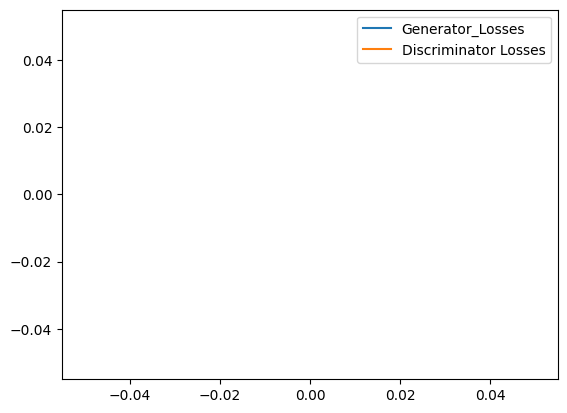

In [8]:
plt.plot(g_losses, label='Generator_Losses')
plt.plot(d_losses, label='Discriminator Losses')
plt.legend()
plt.savefig('loss.png')

In [9]:
def show_new_gen_images(tensor_img, num_img=25):
    tensor_img = (tensor_img + 1) / 2
    unflat_img = tensor_img.detach().cpu()
    img_grid = make_grid(unflat_img[:num_img], nrow=5)
    plt.imshow(img_grid.permute(1, 2, 0).squeeze(),cmap='gray')
    plt.show()

num_image = 25
noise = noise(num_image, 64)
generator.eval()
with torch.inference_mode():
    fake_img = generator(noise)

show_new_gen_images(fake_img.reshape(num_image,1,28,28))

RuntimeError: mat1 and mat2 shapes cannot be multiplied (25x64 and 128x256)